<a href="https://colab.research.google.com/github/vup7bv/project_voting/blob/main/project_3_final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Millie Pandya - vup7bv, Michael McGeachy - mjm2xmm

# Summary

The intended purpose of this project is to utilize Virginia voting data since 2000 to create a model that can predict the outcome of the upcoming 2024 presidential election. To accomplish this, the source data was divided into its Democratic and Republican constituent components, with the primary challenge being to coalesce the various counties and cities together. This was required given that data from various election years might not have differentiated between a city and the county in which it was located. The goal was for this information to be fed into a linear model, which would use historic trends from each voting cycle to extrapolate results for the next cycle. Ultimately, this first attempt at modeling proved to be too simple to be of much use in a real world setting, as evidenced by its resulting map. However, to build upon the lessons learned a second attempt was made that utilized new data on adjacency, and utilized a “smoothing” process to better anticipate the shifting trends that have turned Virginia blue in recent elections. This time the resulting model was a far better representation of recent presidential electoral trends in the real world, and was more indicative of the strong Democratic showings that we have even seen at the state level.


# Package Imports

In [ ]:
import geopandas as gpd
#import mapclassify
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Loading and Cleaning Data

In [ ]:
# The dataframe containing the aggregate voting history for each VA county from 2000 onwards:
voting_VA = pd.read_csv("data/voting_VA.csv", low_memory=False)

# The dataframe containing the VA county adjacencies:
county_adjacencies = pd.read_csv("data/county_adjacencies.csv", low_memory=False)

## First Modeling Attempt

To begin with, we decided to focus on using the VA Voting data file as well as the county adjacencies file because we felt they provided enough information to attempt a first run. This choice was made to simplify the original steps of our modeling process, and based upon how well this data would work with our eventual linear model format.


Realistically speaking, we only will need to consider the Democrat and Republican party data, as predicting the 2024 results, in effect, means deciding which of those two parties will win in each VA county. First, we can use the "voting_VA" data file to extract the total number of votes cast, as well as the counts of these votes for the Democrat and Republican party candidates for each VA county and each past year:

In [ ]:
# First, extracting all of the years and county names:
all_years = []
all_counties = []

for i in range(len(voting_VA)):
    if voting_VA['year'][i] not in all_years:
        all_years.append(voting_VA['year'][i])
    if voting_VA['county_name'][i] not in all_counties:
        all_counties.append(voting_VA['county_name'][i])

print(all_years)
print(all_counties)

[2000, 2004, 2008, 2012, 2016, 2020]
['ACCOMACK', 'ALBEMARLE', 'ALLEGHANY', 'AMELIA', 'AMHERST', 'APPOMATTOX', 'ARLINGTON', 'AUGUSTA', 'BATH', 'BEDFORD', 'BLAND', 'BOTETOURT', 'BRUNSWICK', 'BUCHANAN', 'BUCKINGHAM', 'CAMPBELL', 'CAROLINE', 'CARROLL', 'CHARLES CITY', 'CHARLOTTE', 'CHESTERFIELD', 'CLARKE', 'CRAIG', 'CULPEPER', 'CUMBERLAND', 'DICKENSON', 'DINWIDDIE', 'ESSEX', 'FAIRFAX', 'FAUQUIER', 'FLOYD', 'FLUVANNA', 'FRANKLIN', 'FREDERICK', 'GILES', 'GLOUCESTER', 'GOOCHLAND', 'GRAYSON', 'GREENE', 'GREENSVILLE', 'HALIFAX', 'HANOVER', 'HENRICO', 'HENRY', 'HIGHLAND', 'ISLE OF WIGHT', 'JAMES CITY', 'KING AND QUEEN', 'KING GEORGE', 'KING WILLIAM', 'LANCASTER', 'LEE', 'LOUDOUN', 'LOUISA', 'LUNENBURG', 'MADISON', 'MATHEWS', 'MECKLENBURG', 'MIDDLESEX', 'MONTGOMERY', 'NELSON', 'NEW KENT', 'NORTHAMPTON', 'NORTHUMBERLAND', 'NOTTOWAY', 'ORANGE', 'PAGE', 'PATRICK', 'PITTSYLVANIA', 'POWHATAN', 'PRINCE EDWARD', 'PRINCE GEORGE', 'PRINCE WILLIAM', 'PULASKI', 'RAPPAHANNOCK', 'RICHMOND', 'ROANOKE', 'ROCKB

In [ ]:
# We can now create three 2D numpy arrays, with rows corresponding to each election year and columns corresponding
# to each county, one containing the total vote counts, one containing the Democrat vote counts, and one
# containing the Republican vote counts:

Total = np.zeros((len(all_years), len(all_counties)))
DemocratCounts = np.zeros((len(all_years), len(all_counties)))
RepublicanCounts = np.zeros((len(all_years), len(all_counties)))

for year in all_years:
    for county in all_counties:
        year_index = all_years.index(year)
        county_index = all_counties.index(county)

        for i in range(len(voting_VA)):
            if voting_VA['year'][i] == year and voting_VA['county_name'][i] == county:
                if voting_VA['totalvotes'][i] != 0:
                    Total[year_index][county_index] = voting_VA['totalvotes'][i]

                if voting_VA['party'][i] == 'DEMOCRAT':
                    DemocratCounts[year_index][county_index] += voting_VA['candidatevotes'][i]
                if voting_VA['party'][i] == 'REPUBLICAN':
                    RepublicanCounts[year_index][county_index] += voting_VA['candidatevotes'][i]

In [ ]:
print(Total)
print(DemocratCounts)

[[11925. 36846.  5123. ...     0.     0.     0.]
 [13356. 43726.  7195. ...     0.     0.     0.]
 [15623. 50984.  7369. ...     0.     0.     0.]
 [16051. 53907.  7173. ...     0.     0.     0.]
 [15818. 56726.  7325. ...     0.     0.     0.]
 [16962. 64657.  8203. ... 10717.  6890. 12113.]]
[[ 5092. 16255.  2214. ...     0.     0.     0.]
 [ 5518. 22088.  3203. ...     0.     0.     0.]
 [ 7607. 29792.  3553. ...     0.     0.     0.]
 [ 7655. 29757.  3403. ...     0.     0.     0.]
 [ 6740. 33345.  2166. ...     0.     0.     0.]
 [ 7578. 42466.  2243. ...  4961.  4790.  6610.]]


The zero-vote issues are likely due to some county names, such as some of the various separate cities, not being present in all of the years. For now, we can let those be, and take a separate step to extract the county adjacencies data in a more useful form. What would be useful is a 2D numpy array, where each row and column represents a particular pair of counties, and an entry of "0" in the array indicates that the counties are not adjacent, and an entry of "1" indicates that the counties are adjacent.

In [ ]:
# First, we can all of the county names from the "county_adjacencies" file, as these aren't written identically
# to the "voting_VA" file:

adj_counties = []

for i in range(len(county_adjacencies)):
    if county_adjacencies['County'][i] not in adj_counties:
        adj_counties.append(county_adjacencies['County'][i])

print(adj_counties)

['Accomack', 'Albemarle', 'AlexandriaCity', 'Alleghany', 'Amelia', 'Amherst', 'Appomattox', 'Arlington', 'Augusta', 'Bath', 'Bedford', 'Bland', 'Botetourt', 'BristolCity', 'Brunswick', 'Buchanan', 'Buckingham', 'BuenaVistaCity', 'Campbell', 'Caroline', 'Carroll', 'CharlesCty', 'Charlotte', 'CharlottesvilleCity', 'ChesapeakeCity', 'Chesterfield', 'Clarke', 'ColonialHeightsCity', 'CovingtonCity', 'Craig', 'Culpeper', 'Cumberland', 'DanvilleCity', 'Dickenson', 'Dinwiddie', 'EmporiaCity', 'Essex', 'Fairfax', 'FairfaxCity', 'FallsChurchCity', 'Fauquier', 'Floyd', 'Fluvanna', 'Franklin', 'FranklinCity', 'Frederick', 'FredericksburgCity', 'GalaxCity', 'Giles', 'Gloucester', 'Goochland', 'Grayson', 'Greene', 'Greensville', 'Halifax', 'HamptonCity', 'Hanover', 'HarrisonburgCity', 'Henrico', 'Henry', 'Highland', 'HopewellCity', 'IsleOfWight', 'JamesCty', 'KingAndQueen', 'KingGeorge', 'KingWilliam', 'Lancaster', 'Lee', 'LexingtonCity', 'Loudoun', 'Louisa', 'Lunenburg', 'LynchburgCity', 'Madison',

In [ ]:
# Now, we can make the desired county adjacencies array:

Adjacencies = np.zeros((len(adj_counties), len(adj_counties)))

PossibleAdj = ['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11', 'N12']

for i in range(len(adj_counties)):
    for j in range(len(adj_counties)):
        county1 = adj_counties[i]
        county2 = adj_counties[j]

        for spot in PossibleAdj:
            if county_adjacencies[spot][i] == county2:
                Adjacencies[i][j] = 1

print(Adjacencies)

# If county i is adjacent to county j, then county j should also be adjacent to county i, so as a sanity check,
# we should make sure that this "Adjacencies" array is equal to its transpose:

if np.all(Adjacencies - np.transpose(Adjacencies)) == 0:
    print("True")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
True


Now, we can revisit the VA voting history data, and fix the issues with the zeros/"nan"s. One approach we can take is that for each place name that is not included in at least one of the years, we can see what larger county that place is included as part of in other years, and then for the years that place is included, we can simply add the votes from that place into the column corresponding to the larger county that contains it. By doing so, in the end, we will have the same counties represented in all of the years.

In [ ]:
# First, let's list out all of the counties that are not included in at least one of the years:

not_listed = []

for i in range(len(Total)):
    for j in range(len(Total[0])):
        if Total[i][j] == 0:
            if all_counties[j] not in not_listed:
                not_listed.append(all_counties[j])

print(not_listed)

['ALEXANDRIA CITY', 'BRISTOL CITY', 'BUENA VISTA CITY', 'CHARLOTTESVILLE CITY', 'CHESAPEAKE CITY', 'COLONIAL HEIGHTS CITY', 'COVINGTON CITY', 'DANVILLE CITY', 'EMPORIA CITY', 'FAIRFAX CITY', 'FALLS CHURCH CITY', 'FRANKLIN CITY', 'FREDERICKSBURG CITY', 'GALAX CITY', 'HAMPTON CITY', 'HARRISONBURG CITY', 'HOPEWELL CITY', 'LEXINGTON CITY', 'LYNCHBURG CITY', 'MANASSAS CITY', 'MANASSAS PARK CITY', 'MARTINSVILLE CITY', 'NEWPORT NEWS CITY', 'NORFOLK CITY', 'NORTON CITY', 'PETERSBURG CITY', 'POQUOSON CITY', 'PORTSMOUTH CITY', 'RADFORD CITY', 'RICHMOND CITY', 'ROANOKE CITY', 'SALEM CITY', 'STAUNTON CITY', 'SUFFOLK CITY', 'VIRGINIA BEACH CITY', 'WAYNESBORO CITY', 'WILLIAMSBURG CITY', 'WINCHESTER CITY', 'ALEXANDRIA', 'BRISTOL', 'BUENA VISTA', 'CHARLOTTESVILLE', 'CHESAPEAKE', 'COLONIAL HEIGHTS', 'COVINGTON', 'DANVILLE', 'EMPORIA', 'FALLS CHURCH', 'FREDERICKSBURG', 'GALAX', 'HAMPTON', 'HARRISONBURG', 'HOPEWELL', 'LEXINGTON', 'LYNCHBURG', 'MANASSAS', 'MANASSAS PARK', 'MARTINSVILLE', 'NEWPORT NEWS', '

Now, we need to go through the work of assigning a different county (one that is included in all the years) to each one of these counties. However, before we do so, notice that there are a lot of pairs of names (such as "Charlottesville City" and "Charlottesville") that refer to the same place, but are named different things over different years. To rectify this, we need to write down all sets of names from above that refer to the same place across different years (so that we can combine them together before we do any further data wrangling/processing):

In [ ]:
# In the following list, each element contains sets of names that correspond to the same place across
# different years:

equivalent_places = [['ALEXANDRIA CITY', 'ALEXANDRIA'], ['BRISTOL CITY', 'BRISTOL'], ['BUENA VISTA CITY',\
    'BUENA VISTA'], ['CHARLOTTESVILLE CITY', 'CHARLOTTESVILLE'], ['CHESAPEAKE CITY', 'CHESAPEAKE'],\
    ['COLONIAL HEIGHTS CITY', 'COLONIAL HEIGHTS'], ['COVINGTON CITY', 'COVINGTON'], ['DANVILLE CITY', 'DANVILLE'],\
    ['EMPORIA CITY', 'EMPORIA'], ['FAIRFAX CITY'], ['FALLS CHURCH CITY', 'FALLS CHURCH'], ['FRANKLIN CITY'],\
    ['FREDERICKSBURG CITY', 'FREDERICKSBURG'], ['GALAX CITY', 'GALAX'], ['HAMPTON CITY', 'HAMPTON'], ['HARRISONBURG CITY',\
    'HARRISONBURG'], ['HOPEWELL CITY', 'HOPEWELL'], ['LEXINGTON CITY', 'LEXINGTON'], ['LYNCHBURG CITY', 'LYNCHBURG'],\
    ['MANASSAS CITY', 'MANASSAS'], ['MANASSAS PARK CITY', 'MANASSAS PARK'], ['MARTINSVILLE CITY', 'MARTINSVILLE'],\
    ['NEWPORT NEWS CITY', 'NEWPORT NEWS'], ['NORFOLK CITY', 'NORFOLK'], ['NORTON CITY', 'NORTON'],\
    ['PETERSBURG CITY', 'PETERSBURG'], ['POQUOSON CITY', 'POQUOSON'], ['PORTSMOUTH CITY', 'PORTSMOUTH'],\
    ['RADFORD CITY', 'RADFORD'], ['RICHMOND CITY'], ['ROANOKE CITY'], ['SALEM CITY', 'SALEM'], ['STAUNTON CITY', 'STAUNTON'],\
    ['SUFFOLK CITY', 'SUFFOLK'], ['VIRGINIA BEACH CITY', 'VIRGINIA BEACH'], ['WAYNESBORO CITY', 'WAYNESBORO'],\
    ['WILLIAMSBURG CITY', 'WILLIAMSBURG'], ['WINCHESTER CITY', 'WINCHESTER']]

# As a sanity check, we can make sure that the total number of named places in the above list is equal to the
# total number of names in "not_listed":

total1 = len(not_listed)
total2 = 0

for item in equivalent_places:
    total2 += len(item)

print(total2 - total1)

0


In [ ]:
# Now, we can convert the equivalent place names to their corresponding indices in the original "all_counties"
# array, and make sure that in our previous "Total" 2D array, that there is no year in which more than one
# equivalent name for a place has a nonzero value listed (otherwise, our next combining/merging step will be
# invalid).

equivalent_indices = []

for item in equivalent_places:
    toAppend = []
    for place in item:
        toAppend.append(all_counties.index(place))
    equivalent_indices.append(toAppend)

for year_data in Total:
    for item in equivalent_indices:
        nonzeros = 0
        for place in item:
            if year_data[place] != 0:
                nonzeros += 1
        if nonzeros > 1:
            print("There is an issue!")
            break
    print("No issue with this year :)")

No issue with this year :)
No issue with this year :)
No issue with this year :)
No issue with this year :)
No issue with this year :)
No issue with this year :)


In [ ]:
# Now, we can modify our Total, DemocratCounts, and RepublicanCounts arrays where, for every pair of equivalent
# county names (corresponding to columns in our array), if there is a nonzero value for either one, we list it
# in the column corresponding to the first name in the pair of equivalent names (essentially, merging duplicate
# counties).

# Copying the values in the duplicate columns (place names) all to one consistent column/name:
for year_data in Total:
    for item in equivalent_indices:
        if len(item) > 1:
            if year_data[item[1]] != 0:
                year_data[item[0]] = year_data[item[1]]

for year_data in DemocratCounts:
    for item in equivalent_indices:
        if len(item) > 1:
            if year_data[item[1]] != 0:
                year_data[item[0]] = year_data[item[1]]

for year_data in RepublicanCounts:
    for item in equivalent_indices:
        if len(item) > 1:
            if year_data[item[1]] != 0:
                year_data[item[0]] = year_data[item[1]]

# Listing all of the indices of the duplicate columns/names, which we will delete:
indices_to_delete = []

for item in equivalent_indices:
    if len(item) > 1:
        indices_to_delete.append(item[1])

print(indices_to_delete)

[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128]


In [ ]:
# Now, we can delete the columns corresponding to the duplicate names, which we found above, while also
# making sure to delete the corresponding rows from a copy of the "all_counties" list from earlier,
# so that our new indices still match up with the county names:

all_counties_copy = all_counties.copy()

all_counties_copy = np.delete(all_counties_copy, indices_to_delete, 0)

Total = np.delete(Total, indices_to_delete, 1)
DemocratCounts = np.delete(DemocratCounts, indices_to_delete, 1)
RepublicanCounts = np.delete(RepublicanCounts, indices_to_delete, 1)

In [ ]:
print(Total)

[[ 11925.  36846.   5123.   4788.  11712.   5927.  83559.  25271.   2210.
    2441.   2688.  13840.   5997.   9856.   5454.  20327.   8351.  11001.
    3066.   4994. 110951.   5284.   2493.  12244.   3507.   7226.   9136.
    3831.   9556.  23481.   5739.   8706.   3191.  22392.   6820.  13699.
    8777.   6852.   5412.   3906.  14072.  41585. 114252.  21463.   1437.
   12950.  24492.   2859.   5852.   5769.   5455.   8748.  75653.  10096.
    4591.   5027.   4609.  11654.   4689.  27160.   6145.   6114.   4892.
    5605.   5492.  10483.   7996.   7385.  24255.   9711.   6363.  10900.
  100511.  12697.   3513.  65926.  33442.   7827.  23994.  10792.   9335.
   14452.  11740.   6714.  35021.  34246.   3230.   3906.  16344.  11166.
   20222.   6026.  13310.  10225.  24583.  55199.   6279.   1975.  13224.
   74585.   7782.   2214.  18307.   2080.      0.   5593.      0.   6681.
    2213.  47887.   9958.   6978.   2140.  23506.  12410.   2580.   5694.
   57825.  61946.   1530.  11062.   58

Actually, now we only see a few different instances of "0" total votes left. Let's figure out which counties they correspond to:

In [ ]:
for i in range(6):
    print(i*4 + 2000)
    year_data = Total[i]
    for j in range(len(year_data)):
        if year_data[j] == 0:
            print(all_counties_copy[j])
    print("\n")

2000
FAIRFAX CITY
FRANKLIN CITY
RICHMOND CITY
ROANOKE CITY


2004
FAIRFAX CITY
FRANKLIN CITY
RICHMOND CITY
ROANOKE CITY


2008
FAIRFAX CITY
FRANKLIN CITY
RICHMOND CITY
ROANOKE CITY


2012
FAIRFAX CITY
FRANKLIN CITY
RICHMOND CITY
ROANOKE CITY


2016
FAIRFAX CITY
FRANKLIN CITY
RICHMOND CITY
ROANOKE CITY


2020




Since there are only four error cases left, we can deal with these ones manually. Since all of these counties are excluded in each year besides 2020, a good approach could be to simply add in the 2020 votes of these places into those of the larger area that includes these places in the past years; for Fairfax City, it would be Fairfax, for Franklin City, it would be Franklin, for Richmond City, it would be Richmond, and for Roanoke City, it would be Roanoke. Let's find all of the corresponding indices in our new "all_counties_copy" list:

In [ ]:
pairs_to_check = [['FAIRFAX CITY', 'FAIRFAX'], ['FRANKLIN CITY', 'FRANKLIN'], ['RICHMOND CITY', 'RICHMOND'],\
                 ['ROANOKE CITY', 'ROANOKE']]

the_indices = []

for item in pairs_to_check:
    toAppend = []

    for place in item:
        toAppend.append(list(all_counties_copy).index(place))

    the_indices.append(toAppend)

print(the_indices)

[[104, 28], [106, 32], [124, 75], [125, 76]]


Now, we can combine the votes of these pairs of places for the 2020 year, and then delete the columns corresponding to the now-unused place names:

In [ ]:
for pair in the_indices:
    Total[-1][pair[1]] += Total[-1][pair[0]]
    DemocratCounts[-1][pair[1]] += DemocratCounts[-1][pair[0]]
    RepublicanCounts[-1][pair[1]] += RepublicanCounts[-1][pair[0]]

all_counties_copy = np.delete(all_counties_copy, [104, 106, 124, 125], 0)

Total = np.delete(Total, [104, 106, 124, 125], 1)
DemocratCounts = np.delete(DemocratCounts, [104, 106, 124, 125], 1)
RepublicanCounts = np.delete(RepublicanCounts, [104, 106, 124, 125], 1)

We can now make sure that our "Total" array has no zero values anywhere:

In [ ]:
print(np.any(Total == 0))

False


Now, as a first (super basic) attempt to predict the 2024 voting results for each county, we can simply apply a linear model to each one of the columns (counties), and extrapolate forward one increment. Specifically, we can take the Democrat and Republic voting proportions (percentages) for each county, and extrapolate this forwards one increment, as well as doing the same for the Total vote count:

In [ ]:
# Getting the Democrat and Republican voting proportions:

DemocratProp = DemocratCounts/Total
RepublicanProp = RepublicanCounts/Total

In [ ]:
years = [0,4,8,12,16,20]

# IMPORTANT: SKLEARN IS NOT WORKING FOR SOME REASON, SO WE CAN USE A DIFFERENT PACKAGE FOR LINEAR REGRESSIONS!!!
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# We can use numpy.polyfit with degree=1.

TotalPrediction = []
DemPropPrediction = []
RepPropPrediction = []

for i in range(len(Total[0])):
    TFit = np.polyfit(years, Total[:,i], 1)
    DFit = np.polyfit(years, DemocratProp[:,i], 1)
    RFit = np.polyfit(years, RepublicanProp[:,i], 1)

    TotalPrediction.append(TFit[0]*24 + TFit[1])
    DemPropPrediction.append(DFit[0]*24 + DFit[1])
    RepPropPrediction.append(RFit[0]*24 + RFit[1])

Total2024 = np.array(TotalPrediction)
DemocratProp2024 = np.array(DemPropPrediction)
RepublicanProp2024 = np.array(RepPropPrediction)

In [ ]:
print(DemocratProp2024 - RepublicanProp2024)

[-6.99946874e-02  3.98918796e-01 -4.22288471e-01 -3.85237034e-01
 -3.32614953e-01 -5.10840523e-01  7.00439192e-01 -4.69046620e-01
 -4.57338212e-01 -5.19499191e-01 -7.58729731e-01 -4.89367855e-01
  2.03229300e-01 -9.01527014e-01 -1.13949223e-01 -4.82139148e-01
 -3.62700816e-02 -6.67297456e-01  2.17950458e-01 -2.32390687e-01
  1.36624314e-01 -1.55463354e-01 -6.52027137e-01 -1.77355694e-01
 -9.54012097e-02 -7.59271797e-01 -1.19869822e-01  4.28686955e-02
  1.10424666e+01 -1.66725843e-01 -3.64394194e-01 -8.76189699e-03
 -1.24671065e+00 -2.75151654e-01 -5.96346268e-01 -3.61727827e-01
 -2.13168014e-01 -6.71288233e-01 -2.44568606e-01  1.96441870e-01
 -1.32892364e-01 -2.58745169e-01  3.82524349e-01 -3.09805253e-01
 -4.39035662e-01 -1.69543699e-01  7.56515259e-02 -2.11373566e-01
 -2.03930846e-01 -3.71958432e-01  1.30643461e-02 -8.49418976e-01
  3.29737480e-01 -2.46146558e-01 -1.73741326e-01 -3.15421568e-01
 -3.56581175e-01 -1.12808365e-01 -2.37614216e-01  8.73526676e-02
 -4.71980905e-02 -3.61956

Now, we can plot this prediction on the Virginia map. For example, we can plot the difference between the predicted Democrat proportion and the Republican proportion as follows:

In [ ]:
gdf = gpd.read_file('vafiles/VirginiaCounty_ClippedToShoreline.shx')
cdf = pd.read_csv('data/county_adjacencies.csv')

gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')
del gdf, cdf

<Axes: >

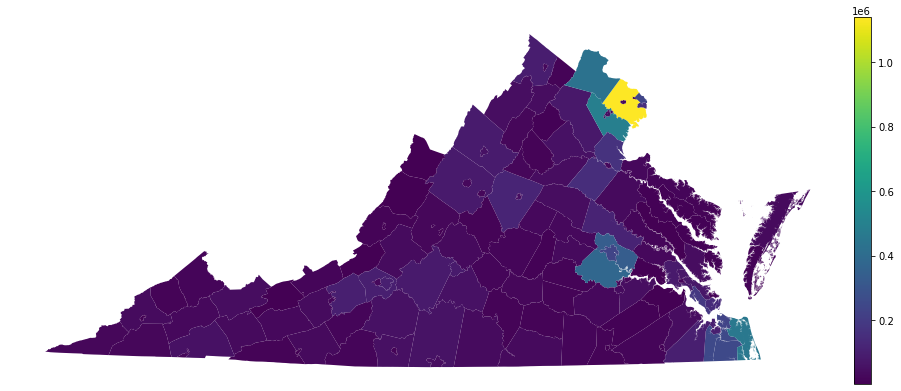

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='Population2022',legend=True,cax=cax)

In [ ]:
print(df)

    STCOFIPS     GNIS            NAME             NAMELSAD GSOURCE LADOPT  \
0      51001  1480091        Accomack      Accomack County       T      N   
1      51003  1675170       Albemarle     Albemarle County       L      Y   
2      51005  1492459       Alleghany     Alleghany County       V      N   
3      51007  1497770          Amelia        Amelia County       T      Y   
4      51009  1480095         Amherst       Amherst County       V      N   
..       ...      ...             ...                  ...     ...    ...   
128    51800  1498560         Suffolk         Suffolk City       L      Y   
129    51810  1498559  Virginia Beach  Virginia Beach City       L      Y   
130    51820  1498443      Waynesboro      Waynesboro City       L      Y   
131    51830  1789076    Williamsburg    Williamsburg City       L      Y   
132    51840  1789077      Winchester      Winchester City       L      Y   

     LASTUPDATE JURISTYPE     AREASQMI    Shape_Leng  ...              N3  

## Okay. So here's the thing. All this time, almost all of the issues dealt with up until this point could have been solved almost instantly by just using the "county_fips" numbers to identify the counties instead of dealing with all of their names. :(

## Anyways, we can still now use the FIPS values to match our fitted data to the map:

In [ ]:
FIPS_List = []

for item in all_counties_copy:
    for j in range(len(voting_VA)):
        if item == voting_VA['county_name'][j]:
            FIPS_List.append(voting_VA['county_fips'][j])
            break

In [ ]:
print(FIPS_List)
print(df['STCOFIPS'])

[51001, 51003, 51005, 51007, 51009, 51011, 51013, 51015, 51017, 51019, 51021, 51023, 51025, 51027, 51029, 51031, 51033, 51035, 51036, 51037, 51041, 51043, 51045, 51047, 51049, 51051, 51053, 51057, 51059, 51061, 51063, 51065, 51067, 51069, 51071, 51073, 51075, 51077, 51079, 51081, 51083, 51085, 51087, 51089, 51091, 51093, 51095, 51097, 51099, 51101, 51103, 51105, 51107, 51109, 51111, 51113, 51115, 51117, 51119, 51121, 51125, 51127, 51131, 51133, 51135, 51137, 51139, 51141, 51143, 51145, 51147, 51149, 51153, 51155, 51157, 51159, 51161, 51163, 51165, 51167, 51169, 51171, 51173, 51175, 51177, 51179, 51181, 51183, 51185, 51187, 51191, 51193, 51195, 51197, 51199, 51510, 51520, 51530, 51540, 51550, 51570, 51580, 51590, 51595, 51610, 51630, 51640, 51650, 51660, 51670, 51678, 51680, 51683, 51685, 51690, 51700, 51710, 51720, 51730, 51735, 51740, 51750, 51775, 51790, 51800, 51810, 51820, 51830, 51840]
0      51001
1      51003
2      51005
3      51007
4      51009
       ...  
128    51800
129  

In [ ]:
dfDEM = []
dfREP = []

theIndex = 0
for i in range(133):
    if int(FIPS_List[theIndex]) - int(df['STCOFIPS'][i]) < 0.5:
        dfDEM.append(DemocratProp2024[theIndex])
        dfREP.append(RepublicanProp2024[theIndex])
        theIndex += 1
    else:
        dfDEM.append(0)
        dfREP.append(0)

In [ ]:
df.insert(29, "DemocratProp2024", dfDEM, True)
df.insert(30, "RepublicanProp2024", dfREP, True)

In [ ]:
df['PDiff'] = df['RepublicanProp2024'] - df['DemocratProp2024']

In [ ]:
print(df['PDiff'])

0      0.069995
1     -0.398919
2      0.422288
3      0.385237
4      0.332615
         ...   
128   -0.219298
129   -0.085022
130    0.020467
131   -0.570207
132   -0.161097
Name: PDiff, Length: 133, dtype: float64


<Axes: >

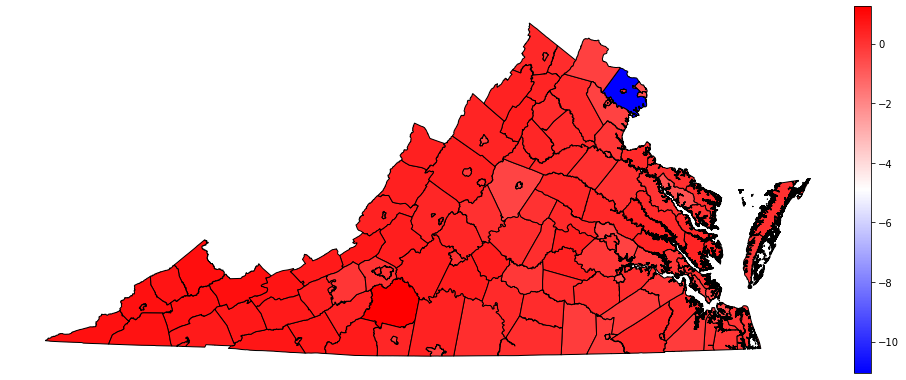

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='PDiff',legend=True,cax=cax,cmap='bwr',edgecolor='k')

Clearly, the linear model is having issues with Fairfax County; a good guess as to why is that the county likely become dramatically more Democrat-favoring in recent years, which would cause a linear model to extrapolate wildly from that. One thing we could do to fix this is to apply a sigmoid function (such as $f(x) = 1/(1 + e^{-x})$) to "squish" the data to a more reasonable range, perhaps more than once; a similar thing could be accomplished with an inverse hyperbolic sinh function.

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

df['PDiff'] = sigmoid(df['RepublicanProp2024'] - df['DemocratProp2024']) - 0.5

Furthermore, we can force the colormap to be centered at zero by dividing all the values larger than $0$ in the dataframe by the maximal positive value, and all values less than $0$ in the dataframe by the magnitude of the lowest value:

In [ ]:
maxVal = max(df['PDiff'])
minVal = abs(min(df['PDiff']))

for i in range(len(df['PDiff'])):
    if df['PDiff'][i] > 0:
        c =  df['PDiff'][i]
        df['PDiff'][i] = c/maxVal
    elif df['PDiff'][i] < 0:
        d =  df['PDiff'][i]
        df['PDiff'][i] = d/minVal

/var/folders/cz/grcpm6h51g176h7xjlnn1gg80000gn/T/ipykernel_98444/2240139081.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PDiff'][i] = c/maxVal
/var/folders/cz/grcpm6h51g176h7xjlnn1gg80000gn/T/ipykernel_98444/2240139081.py:7: Setti

<Axes: >

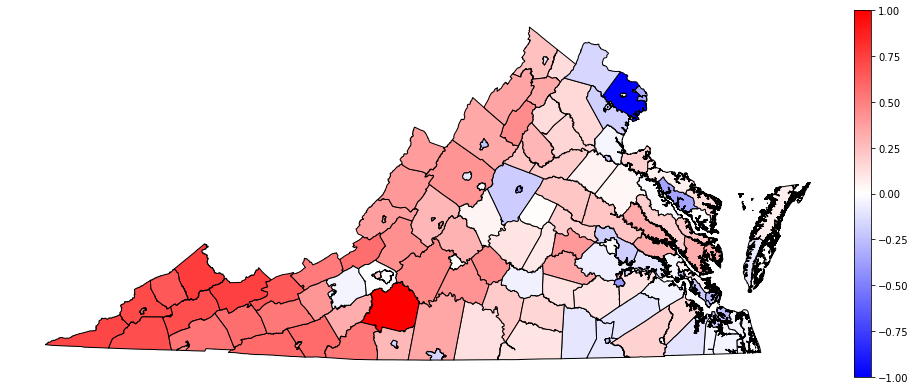

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='PDiff',legend=True,cax=cax,cmap='bwr',edgecolor='k')

# Results from the First Attempt

From our above modeling, we found that the initial attempt at a very simple model, patterned around taking trends and extrapolating forward a year, was not suitable for the real world. This likely has to do with the dramatic changes taking place in the northern regions of the state, particularly Fairfax, that are hard to accurately model when involved with early 2000s data. This would make sense, as broad swaths of the western part of the state, a traditionally conservative belt, are predictably leaning Republican. As a result, the resulting map was somewhat representative of trends, but not nearly as useful of a predictive tool as there could be.

Unfortunately, political trends simply do not act in a linear fashion like we computed above, and this style of model is too inflexible for the swings that characterized Virginia in the late 2000s. Had this modeled a more consistent state, this model might be more representative of potential 2024 results; however, Virginia’s status as a former battleground state, coupled with some significant shifts, have made it incompatible. In order to rectify this, a new, different model is needed that uses an entirely different process to compute its predictive values.

# A SECOND ATTEMPT (USING FIPS AND ADJACENCIES)

That previous attempt was far too simplistic and the results made no real-world sense. We can try again, this time using the FIPS numbers, as well as the county adjacencies. The rough idea will be as follows: for each year, we "smooth" the data for each county by adding in a contribution from the results of its adjacent counties, and then apply a linear model on the "smoothed" data. To keep this attempt completely separate from the previous one, we won't reuse any of the variables from the previous attempt. Maintaining this separation will allow for an unbiased comparison between the two models at the end of this section.

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# The dataframe containing the aggregate voting history for each VA county from 2000 onwards:
voting_VA = pd.read_csv("data/voting_VA.csv", low_memory=False)

# The dataframe containing the VA county adjacencies:
county_adjacencies = pd.read_csv("data/county_adjacencies.csv", low_memory=False)

In [ ]:
# Now, we can organize counties based on increasing FIPS, as well as of course the years.

the_years = []
for item in voting_VA['year']:
    if item not in the_years:
        the_years.append(item)

the_fips = []
for item in voting_VA['county_fips']:
    if item not in the_fips:
        the_fips.append(item)
the_fips.sort()

print(the_years)
print(the_fips)

[2000, 2004, 2008, 2012, 2016, 2020]
[51001, 51003, 51005, 51007, 51009, 51011, 51013, 51015, 51017, 51019, 51021, 51023, 51025, 51027, 51029, 51031, 51033, 51035, 51036, 51037, 51041, 51043, 51045, 51047, 51049, 51051, 51053, 51057, 51059, 51061, 51063, 51065, 51067, 51069, 51071, 51073, 51075, 51077, 51079, 51081, 51083, 51085, 51087, 51089, 51091, 51093, 51095, 51097, 51099, 51101, 51103, 51105, 51107, 51109, 51111, 51113, 51115, 51117, 51119, 51121, 51125, 51127, 51131, 51133, 51135, 51137, 51139, 51141, 51143, 51145, 51147, 51149, 51153, 51155, 51157, 51159, 51161, 51163, 51165, 51167, 51169, 51171, 51173, 51175, 51177, 51179, 51181, 51183, 51185, 51187, 51191, 51193, 51195, 51197, 51199, 51510, 51515, 51520, 51530, 51540, 51550, 51570, 51580, 51590, 51595, 51600, 51610, 51620, 51630, 51640, 51650, 51660, 51670, 51678, 51680, 51683, 51685, 51690, 51700, 51710, 51720, 51730, 51735, 51740, 51750, 51760, 51770, 51775, 51790, 51800, 51810, 51820, 51830, 51840]


In [ ]:
# Now, we can extract the Democrat, Republican, and total vote counts for each year from the "voting_VA" dataframe:

Total = np.zeros((len(the_years), len(the_fips)))
Democrat = np.zeros((len(the_years), len(the_fips)))
Republican = np.zeros((len(the_years), len(the_fips)))

for i in range(len(the_years)):
    for j in range(len(the_fips)):
        year = the_years[i]
        fips = the_fips[j]

        for k in range(len(voting_VA)):
            if voting_VA['year'][k] == year and voting_VA['county_fips'][k] == fips:
                if voting_VA['totalvotes'][k] > Total[i][j]:
                    Total[i][j] = voting_VA['totalvotes'][k]

                if voting_VA['party'][k] == 'DEMOCRAT':
                    Democrat[i][j] += voting_VA['candidatevotes'][k]
                if voting_VA['party'][k] == 'REPUBLICAN':
                    Republican[i][j] += voting_VA['candidatevotes'][k]

In [ ]:
# Now, to extract the county adjacencies. We want a 2D numpy array, where the order of the rows and columns matches
# the order of "the_fips" from earlier. We can also print out any of the FIPS numbers that go unused in the county
# adjacencies file:

adjacencies_order = []

for item in the_fips:
    for i in range(len(county_adjacencies)):
        if county_adjacencies['FIPS'][i] == item:
            adjacencies_order.append(county_adjacencies['County'][i])
            break
        if i == len(county_adjacencies) - 1:
            print(item)

print(adjacencies_order)

51515
['Accomack', 'Albemarle', 'Alleghany', 'Amelia', 'Amherst', 'Appomattox', 'Arlington', 'Augusta', 'Bath', 'Bedford', 'Bland', 'Botetourt', 'Brunswick', 'Buchanan', 'Buckingham', 'Campbell', 'Caroline', 'Carroll', 'CharlesCty', 'Charlotte', 'Chesterfield', 'Clarke', 'Craig', 'Culpeper', 'Cumberland', 'Dickenson', 'Dinwiddie', 'Essex', 'Fairfax', 'Fauquier', 'Floyd', 'Fluvanna', 'Franklin', 'Frederick', 'Giles', 'Gloucester', 'Goochland', 'Grayson', 'Greene', 'Greensville', 'Halifax', 'Hanover', 'Henrico', 'Henry', 'Highland', 'IsleOfWight', 'JamesCty', 'KingAndQueen', 'KingGeorge', 'KingWilliam', 'Lancaster', 'Lee', 'Loudoun', 'Louisa', 'Lunenburg', 'Madison', 'Mathews', 'Mecklenburg', 'Middlesex', 'Montgomery', 'Nelson', 'NewKent', 'Northampton', 'Northumberland', 'Nottoway', 'Orange', 'Page', 'Patrick', 'Pittsylvania', 'Powhatan', 'PrinceEdward', 'PrinceGeorge', 'PrinceWilliam', 'Pulaski', 'Rappahannock', 'Richmond', 'Roanoke', 'Rockbridge', 'Rockingham', 'Russell', 'Scott', 'Sh

The missing FIPS of 51515 corresponds to BEDFORD, which is also listed under FIPS 51019; to fix this, we can simply add in the values for FIPS 51515 into the ones corresponding to FIPS 51019 in our "Total", "Democrat", and "Republican" arrays, and then delete the column corresponding to 51515 from all three arrays, as well as the element from "the_fips":

In [ ]:
theIndex1 = the_fips.index(51515)
theIndex2 = the_fips.index(51019)

for year_data in Total:
    year_data[theIndex2] += year_data[theIndex1]
for year_data in Democrat:
    year_data[theIndex2] += year_data[theIndex1]
for year_data in Republican:
    year_data[theIndex2] += year_data[theIndex1]

Total = np.delete(Total, theIndex1, 1)
Democrat = np.delete(Democrat, theIndex1, 1)
Republican = np.delete(Republican, theIndex1, 1)

the_fips = np.delete(the_fips, theIndex1, 0)

Now, we can extract out the information in the "county_adjacencies" dataframe into a 2D numpy array, like we did before, in the previous attempt:

In [ ]:
Adjacencies = np.zeros((len(adjacencies_order), len(adjacencies_order)))
PossibleAdj = ['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11', 'N12']

for i in range(len(adjacencies_order)):
    for j in range(len(adjacencies_order)):
        county1 = adjacencies_order[i]
        county2 = adjacencies_order[j]

        for spot in PossibleAdj:
            if county_adjacencies[spot][i] == county2:
                Adjacencies[i][j] = 1

print(Adjacencies)

# If county i is adjacent to county j, then county j should also be adjacent to county i, so as a sanity check,
# we should make sure that this "Adjacencies" array is equal to its transpose:

if np.all(Adjacencies - np.transpose(Adjacencies)) == 0:
    print("True")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
True


We can now perform the "smoothing" process that we mentioned before. For each entry in "Total", "Democrat", and "Republican", we can apply a weight of $0.85$ to itself, as well as a weight of $0.15$ split over all of the other counties that are adjacent to it.

In [ ]:
TotalSmooth = 0.85*Total
DemocratSmooth = 0.85*Democrat
RepublicanSmooth = 0.85*Republican

# Making each row in "Adjacencies" sum to 1 to ensure everything remains more or less normalized:
AdjSum = np.sum(Adjacencies, axis=0)
AdjacenciesNorm = Adjacencies/AdjSum
CheckSum = np.sum(AdjacenciesNorm, axis=0)
print(CheckSum)

# Adding in the 0.2-times smoothing terms for each year, based on county adjacencies:
for i in range(len(the_years)):
    ThisTotal = Total[i]
    ThisDemocrat = Democrat[i]
    ThisRepublican = Republican[i]

    TotalCorrection = 0.15*(ThisTotal @ AdjacenciesNorm) # The "@" symbol implements matrix multiplication!
    DemocratCorrection = 0.15*(ThisDemocrat @ AdjacenciesNorm)
    RepublicanCorrection = 0.15*(ThisRepublican @ AdjacenciesNorm)

    TotalSmooth[i] += TotalCorrection
    DemocratSmooth[i] += DemocratCorrection
    RepublicanSmooth[i] += RepublicanCorrection

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Now, we can apply the linear models, as we did before:

In [ ]:
years = [0,4,8,12,16,20]

# IMPORTANT: SKLEARN IS NOT WORKING FOR SOME REASON, SO WE CAN USE A DIFFERENT PACKAGE FOR LINEAR REGRESSIONS!!!
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^
# We can use numpy.polyfit with degree=1.

TotalPrediction = []
DemocratPrediction = []
RepublicanPrediction = []

for i in range(len(TotalSmooth[0])):
    TFit = np.polyfit(years, TotalSmooth[:,i], 1)
    DFit = np.polyfit(years, DemocratSmooth[:,i], 1)
    RFit = np.polyfit(years, RepublicanSmooth[:,i], 1)

    TotalPrediction.append(TFit[0]*24 + TFit[1])
    DemocratPrediction.append(DFit[0]*24 + DFit[1])
    RepublicanPrediction.append(RFit[0]*24 + RFit[1])

Total2024 = np.array(TotalPrediction)
Democrat2024 = np.array(DemocratPrediction)
Republican2024 = np.array(RepublicanPrediction)

In [ ]:
DemocratProp2024 = Democrat2024/Total2024
RepublicanProp2024 = Republican2024/Total2024

Now, we can plot this prediction on the Virginia map. For example, we can plot the difference between the predicted Republican proportion and the Democrat proportion as follows:

In [ ]:
gdf = gpd.read_file('vafiles/VirginiaCounty_ClippedToShoreline.shx')
cdf = pd.read_csv('data/county_adjacencies.csv')

gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')
del gdf, cdf

In [ ]:
df.insert(29, "DemocratProp2024", DemocratProp2024, True)
df.insert(30, "RepublicanProp2024", RepublicanProp2024, True)

In [ ]:
df['PDiff'] = df['RepublicanProp2024'] - df['DemocratProp2024']

<Axes: >

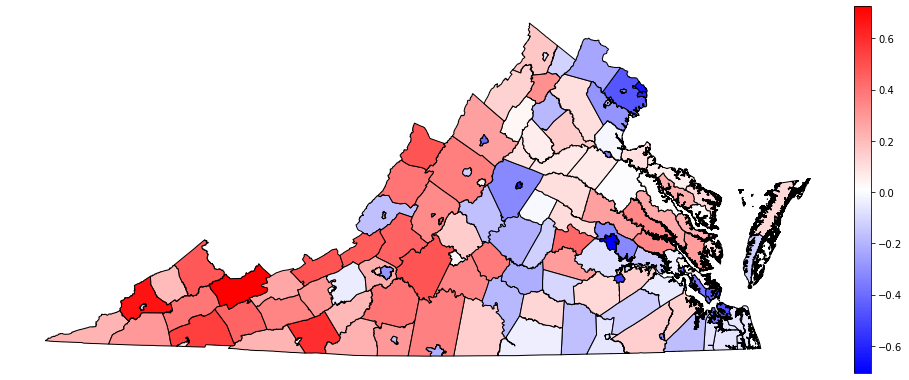

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='PDiff',legend=True,cax=cax,cmap='bwr',edgecolor='k')

The blue zones roughly indicate Democrat favor, and the red zones roughly indicate Republican favor, since the "0" value for this plot falls very close to where the white color is placed.

# Second Model Results

Model 2 results in a significantly more varied map than we had seen before, and serves as a better reflection of what Virginia would look like in 2024. This is evident in its greater portion of Democratic or neutral spaces, which are a reflection of Virginia no longer being the battleground state that it was in the 2000s. This shift is undoubtedly due to the “smoothing” process that was used before, which helped mitigate the impact of outdated data points on the model, and allowed for some interpretation of shifting populations with its .15 weighing of nearby counties.

Notably, this model did a far better job of predicting the strong Democratic performances along the South-East regions of the state. These were areas of strength for Democrats in 2020, and there are valid reasons to assume that these patterns would be exhibited in 2024.


# Conclusion

Virginia is an inherently difficult state to model given its changing status over the past few decades. At the outset of the 2000s it was regarded as a battleground state that could go either way, something that the data would reflect; however, this title largely disappeared after 2008 as populous, solidly-democratic counties closer to DC, with their changing demographics, had greater degrees of influence on the state’s electoral outcome. It is these wild swings that the model likely began to struggle in accurately accommodating them, necessitating the use of a sigmoid function to moderate it out.  

Importantly, the findings of our project are entirely limited to predicting presidential elections. Governor Youngkin’s election would be considered a shock to this model’s findings, demonstrating the restrictions of solely temporal-based data when predicting political outcomes in a rapidly-changing cultural context. For state elections, the gerrymandered nature of those districts represents an entirely new variable that is not accounted for in this analysis, reinforcing our finding’s national applicability. That being said, we feel the overarching accuracy of our model was reinforced by the resurgent performance of the Democratic Party in 2023, the closest statewide election cycle we could compare our findings to.

We accept that the first attempt at modeling was a flawed iteration that served as a learning experience for our second model. It is that second model’s unique smoothing process that we feel helps provide a more accurate result as it builds in an accommodation for the shifting population trends that are changing Virginia. Future work should build upon more recent datasets, particularly those from state elections, which provide further data points to build out the model. In a field such as politics the importance of recent data cannot be understated, particularly given the waves of upheaval that the US has faced for just under a decade. Another potential modeling choice would be to include older data points, but to not weigh them as highly as more recent datasets. This would enable the use of additional information, but acknowledge that population trends do not generally change on a whim. In either scenario, our work serves as a valuable stepping stone in the pursuit of more detailed, complex models that seek to unravel the mysteries of electoral predictions that have baffled political scientists for decades.
